In [19]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter

In [62]:
def zero_pad(Y):
    mx, my = Y.shape
    padded_x = ((mx + 7) // 8) * 8
    padded_y = ((my + 7) // 8) * 8
    img = np.zeros((padded_x, padded_y), dtype=np.uint8)
    img[:mx, :my] = Y
    
    return img

def DCT(img):
    w, h = img.shape
    num_blocks = (w // 8) * (h // 8)
    dct_output = np.zeros((8, 8, num_blocks), dtype=float) 

    for ci, (i, j) in enumerate((x, y) for x in range(0, w, 8) for y in range(0, h, 8)):
        dct_output[:, :, ci] = cv2.dct(img[i:i+8, j:j+8].astype(np.float32))  # Ensure input is float for DCT

    return dct_output


def hist(DC, N=2000):
    hcount, bin_edges = np.histogram(DC, bins=N, density=True)
    plt.figure(figsize=(10, 6))
    sns.histplot(x=bin_edges[:-1], weights=hcount, bins=N, kde=True, stat="density")
    plt.title("DC Coefficient Histogram")
    plt.xlabel("DC Coefficient Value")
    plt.ylabel("Density")
    plt.show()
    return hcount, bin_edges

def FFT(hcount):
  hcount -= np.mean(hcount)
  x = np.fft.fft(hcount.astype(float))
  x = -np.fft.fftshift(x)
#   x = savgol_filter(x, 11, 2)
  return x

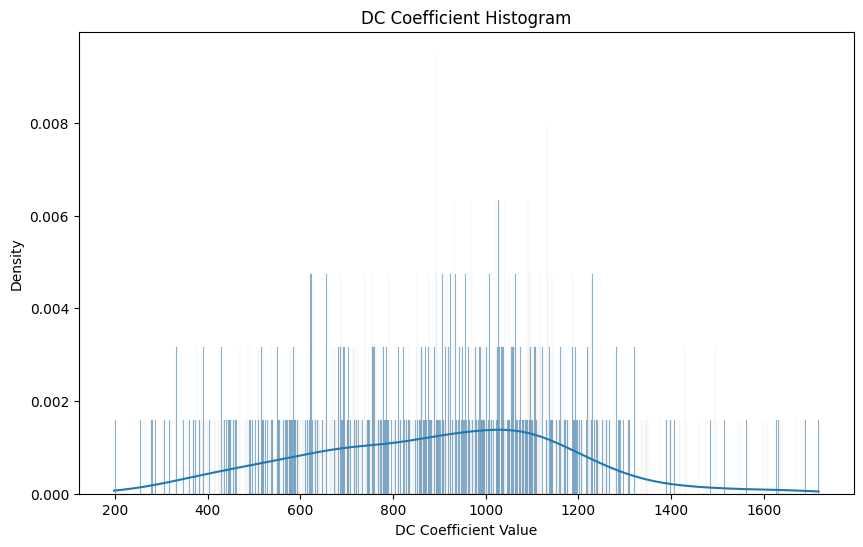

/home/zeffar/Github/JPEG_Detection/.venv/lib64/python3.13/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/zeffar/Github/JPEG_Detection/.venv/lib64/python3.13/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


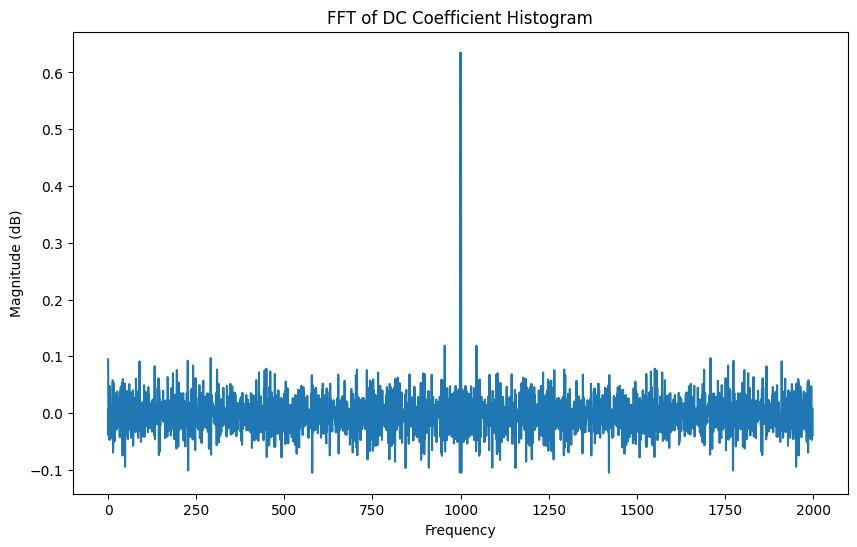

In [63]:

img = Image.open("0010x8.png")

img = img.convert('YCbCr')
img = zero_pad(np.array(img)[:,:,0])
img = img.astype(np.float64)
dct = DCT(img)[0,0,:]
hcount, bin_edges = hist(dct)
fft = FFT(hcount)

plt.figure(figsize=(10, 6))
plt.plot(fft)
plt.title("FFT of DC Coefficient Histogram")
plt.xlabel("Frequency")
plt.ylabel("Magnitude (dB)")
plt.show()



